# ⚙️ IBM Modeling 
With the data explored and prepared, our next adventure in the world of IBM data was to build a statistical "crystal ball": a model capable of predicting which employees are most likely to leave the company.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from joblib import dump

from src.utils import dataframe_coefficients
from src.config import PROCESSED_DATA, FINAL_MODEL
from src.graphics import plot_compare_model_metrics, plot_coefficients
from src.models import RANDOM_STATE
from src.models import (
    classifier_grid_search_cv,
    train_and_validate_classification_model,
    organize_results,
)

sns.set_theme(palette="bright")

### Preparing the Foundation: We started by loading our already clean and processed dataset.

In [2]:
df = pd.read_parquet(PROCESSED_DATA)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
nominal_categorical_columns = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

ordinal_categorical_columns = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

target_column = ["Attrition"]

numerical_columns = [
    column for column in df.columns if column not in (
        nominal_categorical_columns + ordinal_categorical_columns + target_column
    )
]

numerical_columns

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [4]:
numeric_columns_min_max = [
    "DailyRate",
    "HourlyRate",
    "MonthlyRate"
]

numeric_columns_std = ["Age"]

numeric_columns_power_transform = [
    column for column in numerical_columns if column not in (
        numeric_columns_min_max + numeric_columns_std
    )
]

numeric_columns_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

### The first task was to separate our variables into predictors (X) and the target variable, Attrition (y).

In [5]:
X = df.drop(columns=target_column)
y = df[target_column]

In [6]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


### Since machine learning models prefer numbers, we transformed our target variable "Yes" and "No" into 1 and 0, respectively, using LabelEncoder.

In [7]:
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [8]:
le.classes_

array(['No', 'Yes'], dtype=object)

## The Art of Data Transformation: We knew that how we present data to the model is crucial. Therefore, we defined a robust preprocessing pipeline:

In [9]:
kf  = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
tree_preprocessing = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), nominal_categorical_columns),
        ("Ordinal", OrdinalEncoder(categories="auto"), ordinal_categorical_columns),
    ]
)

preprocessing = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), nominal_categorical_columns),
        ("Ordinal", OrdinalEncoder(categories="auto"), ordinal_categorical_columns),
        ("min_max", MinMaxScaler(), numeric_columns_min_max),
        ("stdscaler", StandardScaler(), numeric_columns_std),
        ("power_transform", PowerTransformer(), numeric_columns_power_transform)
    ]
)

In [11]:
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
scale_pos_weight

np.float64(5.2025316455696204)

### Nominal categorical variables (like Gender and Department) were transformed using OneHotEncoder.
### Ordinal categorical variables (like Education Level) were converted to sequential numbers with OrdinalEncoder.
### Numerical variables received specific treatments: MinMaxScaler for those with defined limits (like DailyRate), StandardScaler for Age, and PowerTransformer for other numerical variables, aiming to normalize their distributions.

## In Search of the Best Predictor:

In [12]:
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing,
        "classifier": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": tree_preprocessing,
        "classifier": DecisionTreeClassifier(class_weight="balanced")
    },
    "GradientBoostingClassifier": {
        "preprocessor": tree_preprocessing,
        "classifier": GradientBoostingClassifier(
            random_state=RANDOM_STATE,
        )
    },
    "LGBMClassifier": {
        "preprocessor": tree_preprocessing,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        )
    },
    "XGBClassifier": {
        "preprocessor": tree_preprocessing,
        "classifier": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            scale_pos_weight=scale_pos_weight,
        )
    },
}

### With the data ready, we tested a range of classifiers, from a DummyClassifier (our starting point, to ensure we would do better than a random guess) to more sophisticated models like LogisticRegression, DecisionTreeClassifier, and boosting algorithms like GradientBoostingClassifier, LGBMClassifier, and XGBClassifier. To ensure fairness in the competition, we used stratified cross-validation (StratifiedKFold) and, due to the imbalance in our target class, we calculated scale_pos_weight (approximately 5.2) to give more importance to attrition cases in models that support this parameter, such as XGBoost and LightGBM.

## Evaluating the Competitors: 

In [13]:
results = {
    model_name: train_and_validate_classification_model(X, y, kf, **classifier)
    for model_name, classifier in classifiers.items()
}

df_results = organize_results(results)

df_results

C:\Users\manoe\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\manoe\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\manoe\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\manoe\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\manoe\anaconda3\envs\base_2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with featur

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.000996,0.006513,0.697279,0.48374,0.152381,0.140351,0.166667,0.464685,0.157109,0.007509
1,DummyClassifier,0.000999,0.006025,0.704082,0.479421,0.138614,0.132075,0.145833,0.557927,0.189116,0.007024
2,DummyClassifier,0.001005,0.005005,0.717687,0.47881,0.126316,0.125,0.12766,0.50715,0.161984,0.00601
3,DummyClassifier,0.000997,0.004527,0.72449,0.46563,0.089888,0.095238,0.085106,0.477302,0.15501,0.005524
4,DummyClassifier,0.001014,0.004992,0.721088,0.549746,0.254545,0.222222,0.297872,0.471229,0.154029,0.006006
5,LogisticRegression,0.06801,0.016041,0.738095,0.726118,0.468966,0.350515,0.708333,0.815803,0.562719,0.08405
6,LogisticRegression,0.04732,0.015558,0.768707,0.752795,0.507246,0.388889,0.729167,0.836636,0.619674,0.062878
7,LogisticRegression,0.046001,0.018033,0.758503,0.761521,0.503497,0.375,0.765957,0.838229,0.650953,0.064034
8,LogisticRegression,0.050184,0.015552,0.789116,0.77974,0.537313,0.413793,0.765957,0.842622,0.651174,0.065736
9,LogisticRegression,0.044549,0.016528,0.772109,0.75239,0.503704,0.386364,0.723404,0.787062,0.580918,0.061078


In [14]:
df_results.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001002,0.005412,0.712925,0.491469,0.152349,0.142977,0.164628,0.495659,0.16345,0.006415
DecisionTreeClassifier,0.009425,0.013963,0.788435,0.599271,0.32486,0.333394,0.320213,0.599271,0.218776,0.023388
XGBClassifier,0.210158,0.025271,0.826531,0.664686,0.441594,0.459649,0.425887,0.777781,0.468712,0.235429
LGBMClassifier,0.496002,0.027076,0.823129,0.684999,0.467428,0.454588,0.481117,0.79295,0.497247,0.523078
GradientBoostingClassifier,0.171718,0.017394,0.861224,0.646251,0.431454,0.634,0.328989,0.806407,0.535684,0.189112
LogisticRegression,0.051213,0.016342,0.765306,0.754513,0.504145,0.382912,0.738564,0.82407,0.613087,0.067555


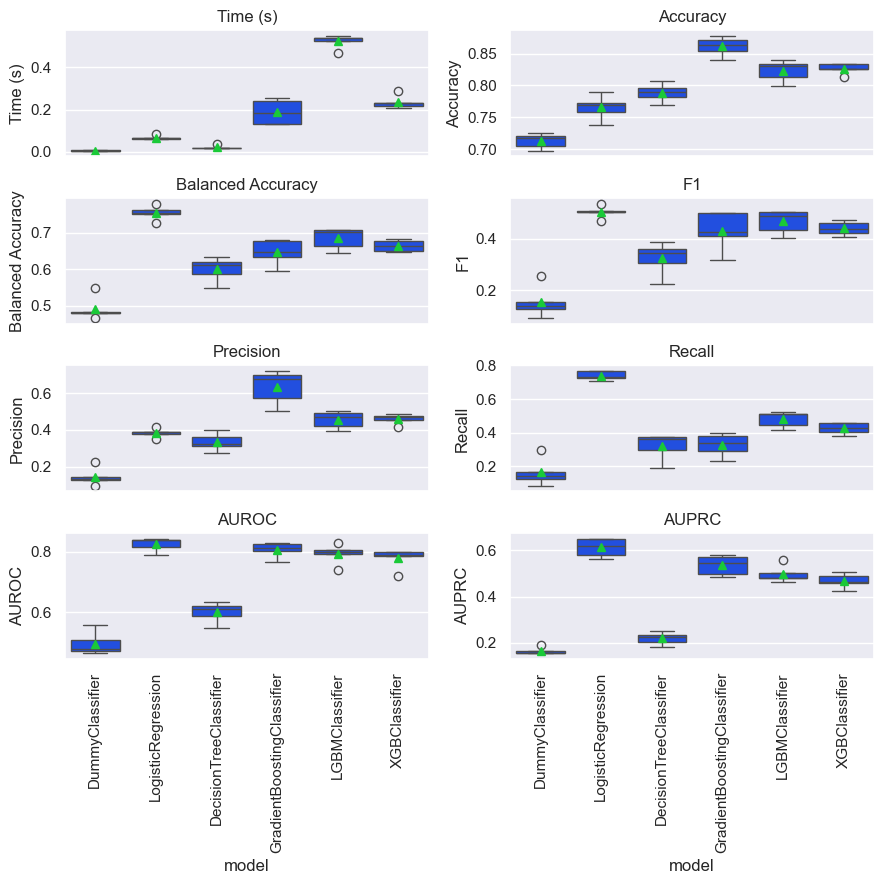

In [15]:
plot_compare_model_metrics(df_results)

### The initial results were promising! Logistic Regression stood out with a good combination of test_average_precision (0.613) and test_roc_auc (0.824), outperforming tree-based models on some important metrics for imbalanced classes.

## Refining the Champion: We then decided to refine our champion, Logistic Regression, using GridSearchCV to find the best hyperparameters (C, penalty, and l1_ratio).

In [16]:
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [17]:
clf = LogisticRegression(solver="saga", random_state=RANDOM_STATE, class_weight="balanced")

grid_search = classifier_grid_search_cv(
    clf, param_grid, kf, preprocessing, refit_metric="average_precision",
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('Ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                                                          'YearsWithCurrManager'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('Ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                                                          'YearsWithCurrManager'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [19]:
grid_search.best_params_

{'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet'}

In [20]:
grid_search.best_score_

np.float64(0.6349983962539747)

In [21]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__l1_ratio', 'param_clf__penalty', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_te

In [22]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('Ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                  PowerTransformer(),
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.5, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [23]:
colunas_test = [coluna for coluna in df_results.columns if coluna.startswith("test")]
colunas_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [24]:
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [25]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.7605442176870748
mean_test_balanced_accuracy: 0.7482709483180627
mean_test_f1: 0.49647644086126974
mean_test_precision: 0.3765470961861631
mean_test_recall: 0.7301418439716312
mean_test_roc_auc: 0.8237225183432815
mean_test_average_precision: 0.6349983962539747


### After an exhaustive search, we found the optimal combination: {'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet'}. This fine-tuning increased our average_precision to approximately 0.635.

## Unveiling the Model: With the best model in hand, we analyzed its coefficients.

In [26]:
coefs = dataframe_coefficients(
    grid_search.best_estimator_["clf"].coef_[0],
    grid_search.best_estimator_["preprocessor"].get_feature_names_out()
)

coefs

,coefficient
Ordinal__JobInvolvement,-0.408202
power_transform__MonthlyIncome,-0.400248
one_hot__Department_Research & Development,-0.339218
Ordinal__EnvironmentSatisfaction,-0.327133
Ordinal__JobSatisfaction,-0.296962
power_transform__TotalWorkingYears,-0.288454
power_transform__YearsInCurrentRole,-0.229396
power_transform__YearsWithCurrManager,-0.226763
min_max__DailyRate,-0.217531
Ordinal__WorkLifeBalance,-0.205558


In [27]:
coefs.query("coefficient == 0")

,coefficient
Ordinal__Education,0.0
one_hot__JobRole_Sales Executive,0.0
one_hot__JobRole_Manufacturing Director,0.0
one_hot__JobRole_Manager,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__EducationField_Marketing,0.0
min_max__MonthlyRate,0.0
Ordinal__PerformanceRating,0.0
min_max__HourlyRate,0.0
one_hot__JobRole_Research Director,0.0


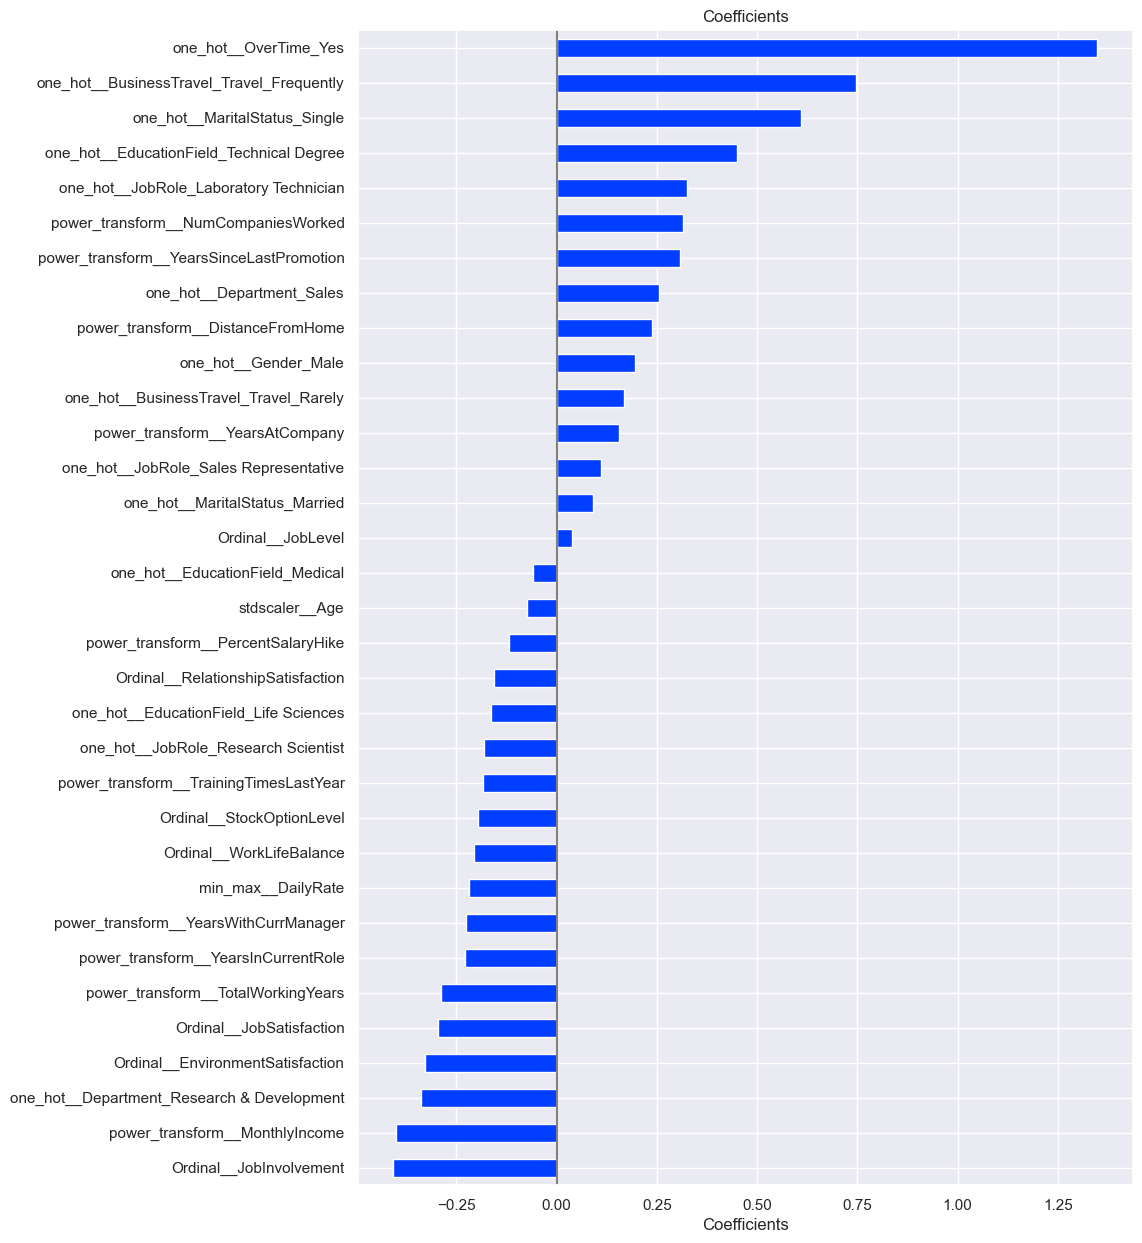

In [28]:
plot_coefficients(coefs.query("coefficient != 0"))

In [29]:
coefs_odds = coefs.copy()
coefs_odds["coefficient"] = np.exp(coefs_odds["coefficient"])

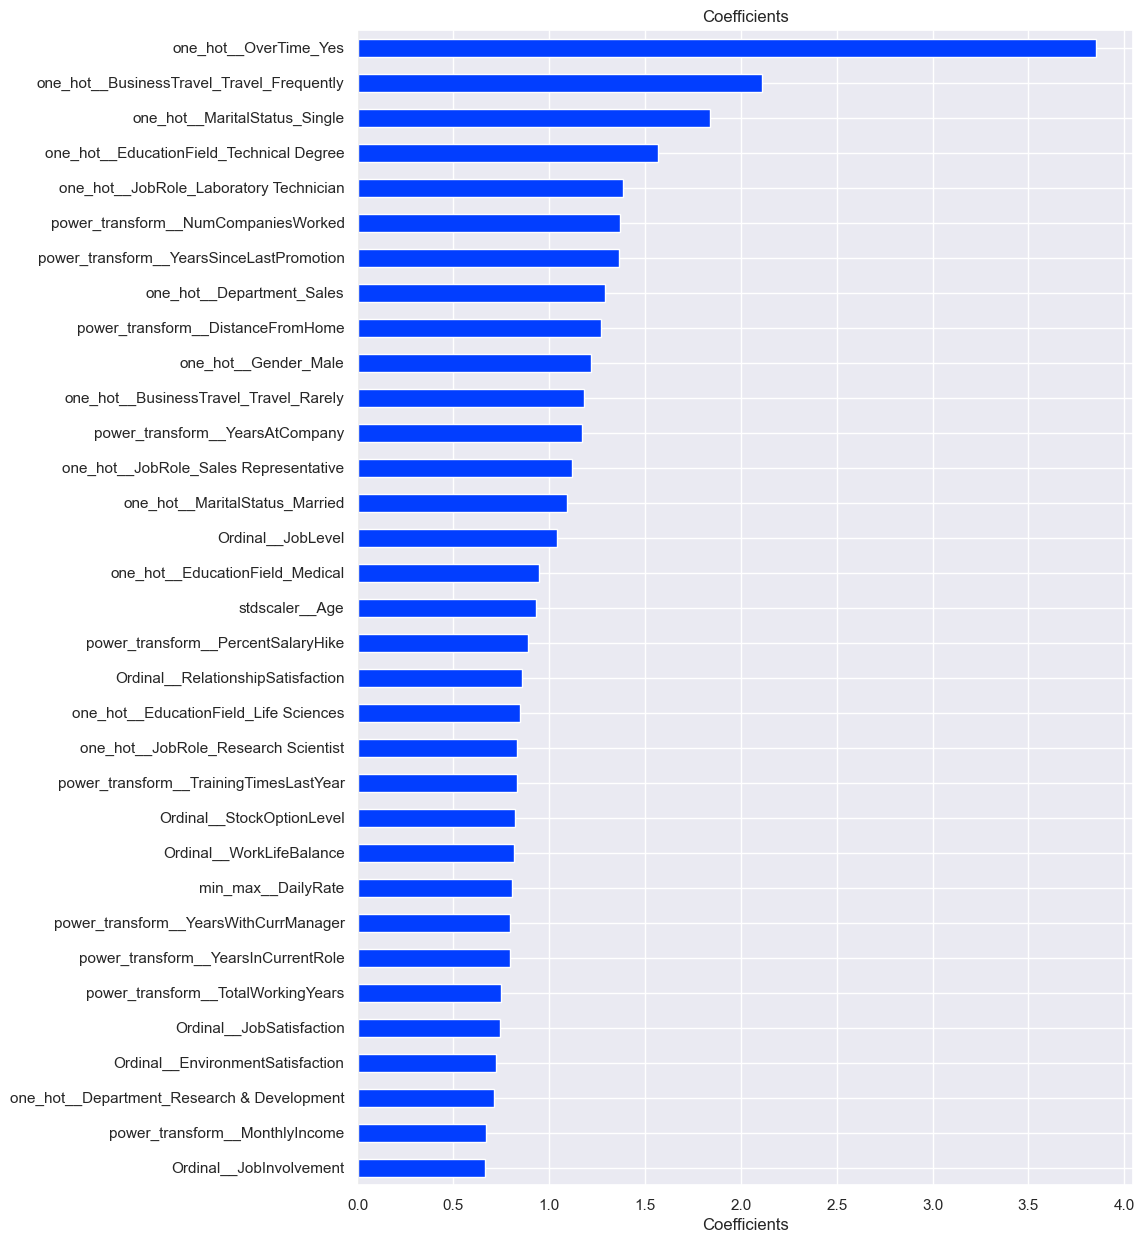

In [30]:
plot_coefficients(coefs_odds.query("coefficient != 1"))

### We discovered that factors like working OverTime, frequent business travel (BusinessTravel_Travel_Frequently), and being single (MaritalStatus_Single) increased the chance of attrition. On the other hand, high job involvement (Ordinal__JobInvolvement) and higher monthly income (power_transform__MonthlyIncome) seemed to retain talent.

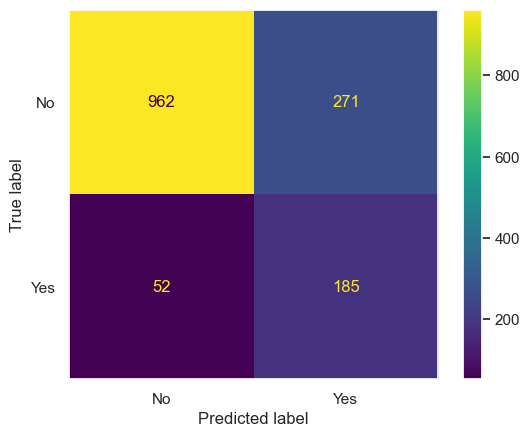

In [31]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
)
plt.grid(False)
plt.show()

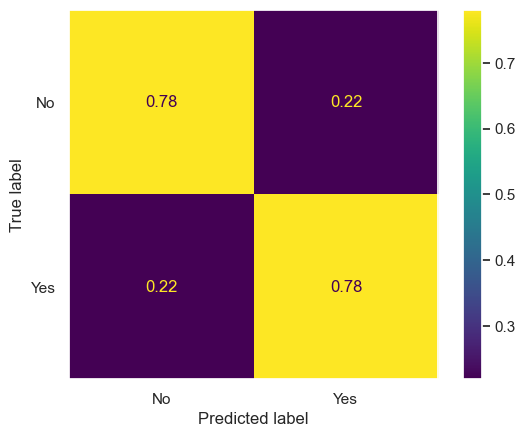

In [32]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize="true"
)
plt.grid(False)
plt.show()

## **Action Plan**

- Assess the reasons that lead employees to work overtime.
- Insufficient workforce
- Lack of institutional organization
- Lack of training
- Need to invest in technology
- Possibility of reducing business travel.
- How does this affect the sales team?
- How does the monthly income of each sector and the company's level compare to the market?

In [33]:
dump(grid_search.best_estimator_, FINAL_MODEL)

['C:\\Users\\manoe\\Área de Trabalho\\IDES\\Estudos\\Hashtag\\Ciencia de Dados\\Projetos\\22. IBM - attrition\\models\\logistic_regression.joblib']

#### Next Steps: The final model was saved, ready to be deployed in a web application, allowing predict and, perhaps, mitigate the loss of its valuable employees.